# Wstęp do sieci neuronowych

Klasyfikacja obrazków MNIST-10 (czarno-białe zdjęcia ręcznie pisanych cyfr).

In [1]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
import random
import os
from sklearn.metrics import confusion_matrix
import seaborn as sns

2025-04-03 18:23:05.311182: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-03 18:23:05.332774: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1743697385.369485  255532 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1743697385.380640  255532 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1743697385.407202  255532 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

In [ ]:
# for reproducibility

def set_seed(seed=42):
    tf.random.set_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    
set_seed(42)

In [3]:
# check if GPU or TPU is available

def check_device():
    print("Available devices:")
    print(tf.config.list_physical_devices())
    print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
    print("Num TPUs Available: ", len(tf.config.list_physical_devices('TPU')))
    print("Num CPUs Available: ", len(tf.config.list_physical_devices('CPU')))

check_device()

Available devices:
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Num GPUs Available:  1
Num TPUs Available:  0
Num CPUs Available:  1


In [4]:
# load the MNIST dataset

def load_mnist():
    (x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()
    x_train = x_train.astype('float32') / 255.0
    x_test = x_test.astype('float32') / 255.0
    return (x_train, y_train), (x_test, y_test)

(x_train, y_train), (x_test, y_test) = load_mnist()
print("Training data shape:", x_train.shape, y_train.shape)
print("Testing data shape:", x_test.shape, y_test.shape)


Training data shape: (60000, 28, 28) (60000,)
Testing data shape: (10000, 28, 28) (10000,)


In [5]:
# create validation set from training data

def create_validation_set(x_train, y_train, val_size=0.1):
    num_classes = len(np.unique(y_train))
    val_indices = []
    for i in range(num_classes):
        class_indices = np.where(y_train == i)[0]
        np.random.shuffle(class_indices)
        val_count = int(len(class_indices) * val_size)
        val_indices.extend(class_indices[:val_count])
    x_val = x_train[val_indices]
    y_val = y_train[val_indices]
    x_train = np.delete(x_train, val_indices, axis=0)
    y_train = np.delete(y_train, val_indices, axis=0)
    return (x_train, y_train), (x_val, y_val)

(x_train, y_train), (x_val, y_val) = create_validation_set(x_train, y_train, val_size=0.1)
print("New training data shape:", x_train.shape, y_train.shape)
print("Validation data shape:", x_val.shape, y_val.shape)

New training data shape: (54004, 28, 28) (54004,)
Validation data shape: (5996, 28, 28) (5996,)


In [6]:
# use a subset of the data for faster training

# def use_subset(x, y, num_samples=1000):
#     indices = np.random.choice(len(x), num_samples, replace=False)
#     return x[indices], y[indices]

# x_train, y_train = use_subset(x_train, y_train, num_samples=1000)
# x_val, y_val = use_subset(x_val, y_val, num_samples=200)
# x_test, y_test = use_subset(x_test, y_test, num_samples=200)

# print("Subset training data shape:", x_train.shape, y_train.shape)
# print("Subset validation data shape:", x_val.shape, y_val.shape)
# print("Subset testing data shape:", x_test.shape, y_test.shape)

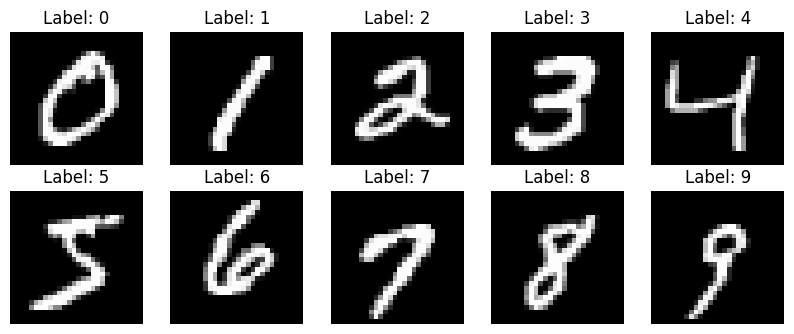

In [7]:
# visualize some samples from the dataset for each class

def visualize_samples(x, y):
    plt.figure(figsize=(10, 10))
    for i in range(10):
        plt.subplot(5, 5, i + 1)
        plt.imshow(x[y == i][0], cmap='gray')
        plt.title(f"Label: {i}")
        plt.axis('off')
    plt.show()
    
visualize_samples(x_train, y_train)

In [8]:
# save one image per class to a directory

def save_samples(x, y, save_dir='samples'):
    os.makedirs(save_dir, exist_ok=True)
    for i in range(10):
        class_indices = np.where(y == i)[0]
        sample_image = x[class_indices[0]]
        plt.imsave(os.path.join(save_dir, f'class_{i}.png'), sample_image, cmap='gray')
        
save_samples(x_train, y_train)

In [9]:
# create model

def create_model():
    # Define a simple feedforward neural network
    model = keras.Sequential([
        keras.layers.InputLayer(shape=(28, 28)),
        keras.layers.Flatten(),
        keras.layers.Dense(128),
        keras.layers.ReLU(),
        keras.layers.Dense(32),
        keras.layers.ReLU(),
        keras.layers.Dense(10),
        keras.layers.Softmax()
    ])
    
    # Compile the model
    model.compile(
        optimizer='adam',
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

In [10]:
model = create_model()
model.summary()

I0000 00:00:1743697390.467528  255532 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 3620 MB memory:  -> device: 0, name: NVIDIA RTX A1000 6GB Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten (Flatten)               │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       100,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu (ReLU)                    │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         4,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_1 (ReLU)                  │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 10)             │           330 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ softmax (Softmax)               │ (None, 10)             │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 104,938 (409.91 KB)

 Trainable params: 104,938 (409.91 KB)

 Non-trainable params: 0 (0.00 B)

In [11]:
def train_model(model, x_train, y_train, x_val, y_val, epochs=10):
    history = model.fit(
        x_train,
        y_train,
        validation_data=(x_val, y_val),
        epochs=epochs,
        batch_size=32,
        verbose=1
    )
    return history

In [12]:
# train the model

history = train_model(model, x_train, y_train, x_val, y_val, epochs=5)

Epoch 1/5


I0000 00:00:1743697392.472925  255690 service.cc:152] XLA service 0x7f71780043c0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1743697392.472978  255690 service.cc:160]   StreamExecutor device (0): NVIDIA RTX A1000 6GB Laptop GPU, Compute Capability 8.6
2025-04-03 18:23:12.493894: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1743697392.611316  255690 cuda_dnn.cc:529] Loaded cuDNN version 90300


  41/1688 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.3902 - loss: 1.9273

I0000 00:00:1743697394.838480  255690 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1688/1688 ━━━━━━━━━━━━━━━━━━━━ 14s 6ms/step - accuracy: 0.8648 - loss: 0.4695 - val_accuracy: 0.9576 - val_loss: 0.1487
Epoch 2/5
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - accuracy: 0.9617 - loss: 0.1275 - val_accuracy: 0.9670 - val_loss: 0.1087
Epoch 3/5
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.9748 - loss: 0.0833 - val_accuracy: 0.9723 - val_loss: 0.0969
Epoch 4/5
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - accuracy: 0.9805 - loss: 0.0600 - val_accuracy: 0.9736 - val_loss: 0.0938
Epoch 5/5
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.9869 - loss: 0.0435 - val_accuracy: 0.9740 - val_loss: 0.0967


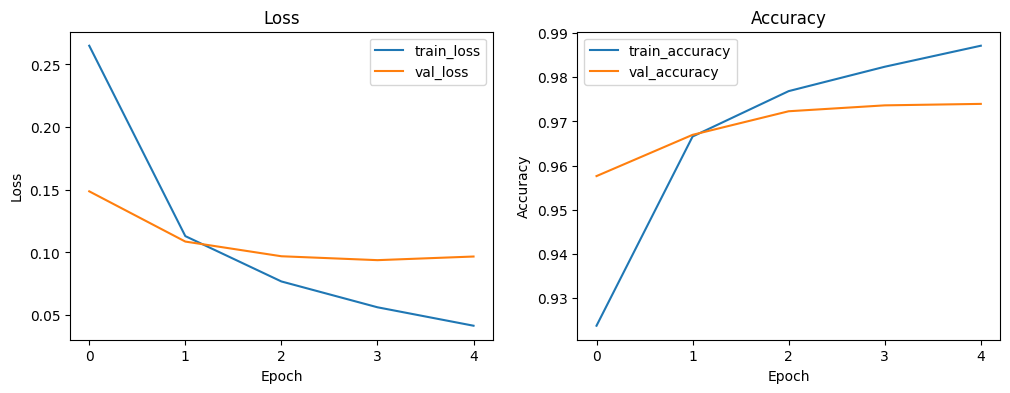

In [13]:
# plot with history loss and accuracy

def plot_history(history):
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='train_loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.title('Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.xticks(np.arange(0, len(history.history['loss']), 1))
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='train_accuracy')
    plt.plot(history.history['val_accuracy'], label='val_accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.xticks(np.arange(0, len(history.history['accuracy']), 1))
    plt.legend()
    
plt.figure(figsize=(12, 4))
plot_history(history)
plt.show()

In [14]:
def evaluate_model(model, x, y):
    loss, accuracy = model.evaluate(x, y, verbose=0)
    return loss, accuracy

def show_accuracy_table(model, x_train, y_train, x_val, y_val, x_test, y_test):
    train_loss, train_accuracy = evaluate_model(model, x_train, y_train)
    val_loss, val_accuracy = evaluate_model(model, x_val, y_val)
    test_loss, test_accuracy = evaluate_model(model, x_test, y_test)

    print(f"{'Dataset':<15} {'Loss':<10} {'Accuracy':<10}")
    print("-" * 35)
    print(f"{'Train':<15} {train_loss:<10.4f} {train_accuracy:<10.4f}")
    print(f"{'Validation':<15} {val_loss:<10.4f} {val_accuracy:<10.4f}")
    print(f"{'Test':<15} {test_loss:<10.4f} {test_accuracy:<10.4f}")
    
show_accuracy_table(model, x_train, y_train, x_val, y_val, x_test, y_test)

Dataset         Loss       Accuracy  
-----------------------------------
Train           0.0332     0.9886    
Validation      0.0967     0.9740    
Test            0.0966     0.9721    


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


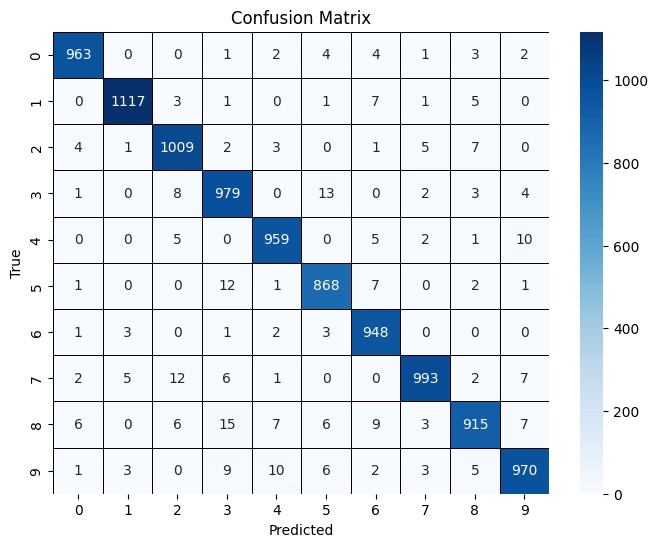

In [15]:
# show conflusion matrix on test set

def plot_confusion_matrix(y_true, y_pred, classes):
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes, linecolor='black', linewidths=0.5)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')

plt.figure(figsize=(8, 6))
plot_confusion_matrix(y_test, model.predict(x_test).argmax(axis=1), classes=np.arange(10))
plt.show()

In [16]:
# save the model

def save_model(model, model_name):
    model.save(model_name)
    print(f"Model saved as {model_name}")

save_model(model, model_name='mnist_model.keras')

Model saved as mnist_model.keras
